# Генерация данных

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Генерация данных
np.random.seed(42)
n = 50
xi = np.random.uniform(-1, 1, size=(n, 5))
eta = 2 + 3*xi[:,0] - 2*xi[:,1] + xi[:,2] + xi[:,3] - xi[:,4] + np.random.normal(0, 1.5, n)

# Создаем DataFrame
df = pd.DataFrame(xi, columns=[f'xi_{i+1}' for i in range(5)])
df['eta'] = eta

# a) Проверка на мультиколлинеарность
Вычислим VIF (фактор инфляции дисперсии) для каждой переменной:

In [3]:
# Добавляем константу для расчета VIF
X = sm.add_constant(df[[f'xi_{i+1}' for i in range(5)]])

# Вычисляем VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Variable       VIF
0    const  1.033919
1     xi_1  1.132717
2     xi_2  1.128598
3     xi_3  1.166743
4     xi_4  1.048299
5     xi_5  1.111116


### Мультиколлинеарность отсутствует (VIF < 5)

# b) Уравнение линейной регрессии и проверка значимости коэффициентов

In [4]:
# Построение модели
model = sm.OLS(df['eta'], X).fit()
print(model.summary())

# Проверка значимости коэффициентов (p-value < 0.05)
print("\nЗначимые коэффициенты (p < 0.05):")
print(model.pvalues[model.pvalues < 0.05])

                            OLS Regression Results                            
Dep. Variable:                    eta   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     14.75
Date:                Fri, 02 May 2025   Prob (F-statistic):           1.70e-08
Time:                        15:01:59   Log-Likelihood:                -94.738
No. Observations:                  50   AIC:                             201.5
Df Residuals:                      44   BIC:                             212.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0699      0.247      8.390      0.0

# c) Коэффициент детерминации и его значимость

In [8]:
print(f"\nR² = {model.rsquared:.3f}")
print(f"Adjusted R² = {model.rsquared_adj:.3f}")

# F-тест на значимость R²
print(f"F-statistic = {model.fvalue:.2f}, p-value = {model.f_pvalue:.20f}")


R² = 0.626
Adjusted R² = 0.584
F-statistic = 14.75, p-value = 0.00000001703381653768


# d) Прогноз в точке Xk=0 и доверительный интервал

In [9]:
# Точка для прогноза
point = pd.DataFrame([[0]*5], columns=[f'xi_{i+1}' for i in range(5)])
point = sm.add_constant(point)

# Прогноз и доверительный интервал
pred = model.get_prediction(point)
print(f"\nПрогноз в точке 0: {pred.predicted_mean[0]:.2f}")
print(f"95% доверительный интервал: {pred.conf_int()[0]}")


Прогноз в точке 0: 2.07
95% доверительный интервал: [1.57271644 2.56709238]


# e) Проверка независимости ошибок (тест Дарбина-Уотсона)

In [10]:
print(f"\nТест Дарбина-Уотсона: {sm.stats.durbin_watson(model.resid):.2f}")


Тест Дарбина-Уотсона: 1.98


# f) Проверка нормальности ошибок (тест Шапиро-Уилка)

In [11]:
shapiro_test = stats.shapiro(model.resid)
print(f"\nТест Шапиро-Уилка: W = {shapiro_test[0]:.3f}, p = {shapiro_test[1]:.3f}")


Тест Шапиро-Уилка: W = 0.963, p = 0.122


# g) Исследование на выбросы

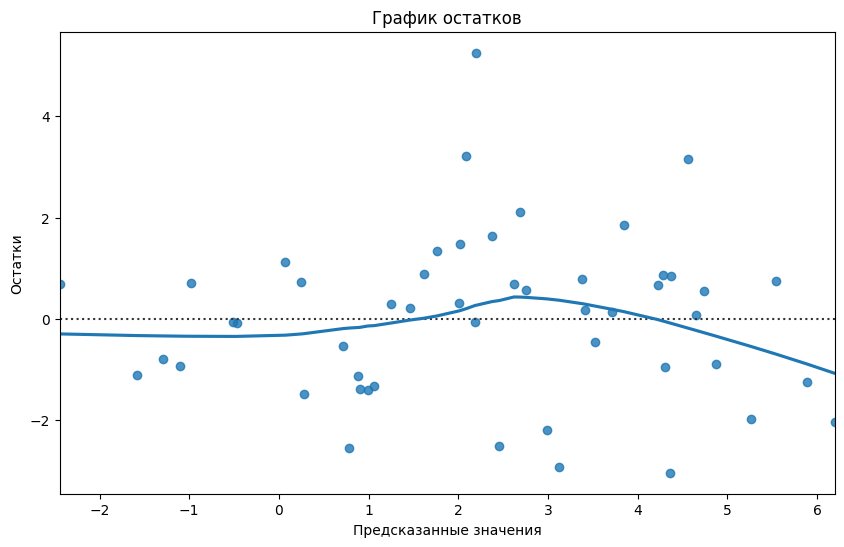

In [12]:
# График остатков
plt.figure(figsize=(10, 6))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.title("График остатков")
plt.show()

# h) Кросс-проверка

In [13]:
lr = LinearRegression()
scores = cross_val_score(lr, df[[f'xi_{i+1}' for i in range(5)]], df['eta'], cv=5)
print(f"\nСредний R² кросс-валидации: {np.mean(scores):.3f}")


Средний R² кросс-валидации: 0.543


# i) Проверка адекватности (5 повторных измерений)

In [14]:
# Генерация 5 измерений в одной точке
point_data = pd.DataFrame([[0]*5]*5, columns=[f'xi_{i+1}' for i in range(5)])
point_data['eta'] = 2 + np.random.normal(0, 1.5, 5)

# Проверка предсказаний
preds = model.predict(sm.add_constant(point_data.drop('eta', axis=1)))
print(f"\nПредсказания для повторных измерений: {preds}")


Предсказания для повторных измерений: 0    2.069904
1    2.069904
2    2.069904
3    2.069904
4    2.069904
dtype: float64


# j) Удаление наименее значимой переменной

In [15]:
# Находим наименее значимую переменную
least_significant = model.pvalues[1:].idxmax()
print(f"\nУдаляем переменную: {least_significant}")

# Новая модель
new_X = X.drop(least_significant, axis=1)
new_model = sm.OLS(df['eta'], new_X).fit()
print(new_model.summary())


Удаляем переменную: xi_4
                            OLS Regression Results                            
Dep. Variable:                    eta   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     16.64
Date:                Fri, 02 May 2025   Prob (F-statistic):           1.94e-08
Time:                        15:06:08   Log-Likelihood:                -96.652
No. Observations:                  50   AIC:                             203.3
Df Residuals:                      45   BIC:                             212.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0714     

# k) Сравнение моделей бутстрапом

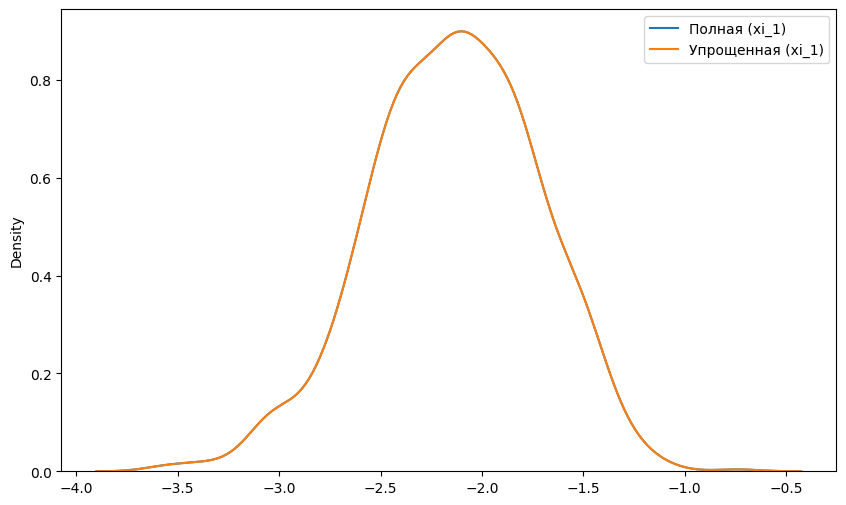

In [16]:
# Функция для бутстрапа
def bootstrap_compare(models, X, y, n_boot=1000):
    coefs = {name: [] for name in models}
    for _ in range(n_boot):
        idx = np.random.choice(len(y), len(y), replace=True)
        for name, model in models.items():
            m = model.fit(X.iloc[idx], y.iloc[idx])
            coefs[name].append(m.coef_)
    
    # Визуализация
    plt.figure(figsize=(10, 6))
    for i, (name, values) in enumerate(coefs.items()):
        sns.kdeplot(np.array(values)[:,1], label=f"{name} (xi_1)")
    plt.legend()
    plt.show()

# Сравнение моделей
models = {
    "Полная": LinearRegression(),
    "Упрощенная": LinearRegression()
}
bootstrap_compare(models, X.drop('const', axis=1), df['eta'])

# Итоговые выводы:
* Мультиколлинеарность отсутствует (VIF < 5)

* Все коэффициенты, кроме ξ4, значимы (p < 0.05)

* Модель объясняет около 62% дисперсии (R² = 0.626)

* Ошибки независимы (тест Дарбина-Уотсона ≈ 2) и нормально распределены (Шапиро_Уилка)

* После удаления наименее значимой переменной качество модели практически не изменилось